In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (_, _) = mnist.load_data()

x_train = x_train / 127.5 - 1.0
x_train = np.expand_dims(x_train, axis=-1)

y_train_onehot = to_categorical(y_train, num_classes=10)

In [2]:
from tensorflow.keras import layers, models

def build_generator_cgan(z_dim, num_classes=10):
    noise_input = layers.Input(shape=(z_dim,))
    label_input = layers.Input(shape=(num_classes,))

    x = layers.Concatenate()([noise_input, label_input])

    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)

    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)

    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)

    img_output = layers.Dense(28*28, activation='tanh')(x)
    img_output = layers.Reshape((28,28,1))(img_output)

    return models.Model([noise_input, label_input], img_output)

In [3]:
def build_discriminator_cgan(img_shape=(28,28,1), num_classes=10):
    img_input = layers.Input(shape=img_shape)
    label_input = layers.Input(shape=(num_classes,))

    x = layers.Flatten()(img_input)
    y = layers.Dense(np.prod(img_shape))(label_input)

    concatenated = layers.Concatenate()([x, y])
    x = layers.Dense(512)(concatenated)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    validity = layers.Dense(1, activation='sigmoid')(x)

    return models.Model([img_input, label_input], validity)

In [8]:
from tensorflow.keras import optimizers

z_dim = 100
num_classes = 10
img_shape = (28,28,1)

generator = build_generator_cgan(z_dim, num_classes)
discriminator = build_discriminator_cgan(img_shape, num_classes)

discriminator.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(0.0001, 0.5),
    metrics=['accuracy']
)

discriminator.trainable = False
z_noise = layers.Input(shape=(z_dim,))
label_input = layers.Input(shape=(num_classes,))
gen_img = generator([z_noise, label_input])
validity = discriminator([gen_img, label_input])
cgan = models.Model([z_noise, label_input], validity)
cgan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.0001, 0.5))

In [9]:
import matplotlib.pyplot as plt

def sample_images_cgan(epoch, n_classes=10):
    noise = np.random.normal(0, 1, (n_classes, z_dim))
    labels = np.eye(n_classes)  

    gen_imgs = generator.predict([noise, labels], verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5 

    fig, axs = plt.subplots(1, n_classes, figsize=(10,2))
    for i in range(n_classes):
        axs[i].imshow(gen_imgs[i,:,:,0], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(str(i))
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

In [12]:
def train_cgan(epochs, batch_size=128, sample_interval=1000):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        labels = y_train_onehot[idx]

        noise = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([noise, labels], verbose=0)

        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, z_dim))
        sampled_labels = np.random.randint(0, 10, batch_size)
        sampled_labels_onehot = to_categorical(sampled_labels, num_classes=10)

        g_loss = cgan.train_on_batch([noise, sampled_labels_onehot], real)

        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
            sample_images_cgan(epoch)

0 [D loss: 0.8358, acc.: 35.72%] [G loss: 0.4567]


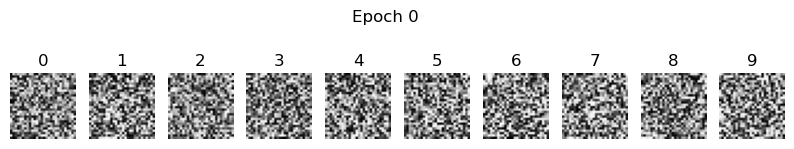

1000 [D loss: 2.8009, acc.: 32.00%] [G loss: 0.0301]


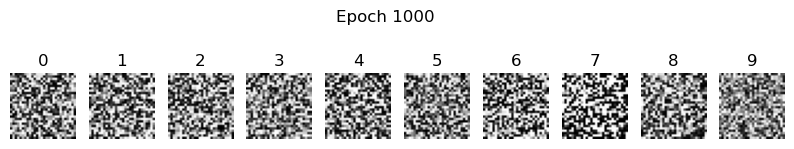

2000 [D loss: 3.2645, acc.: 32.01%] [G loss: 0.0158]


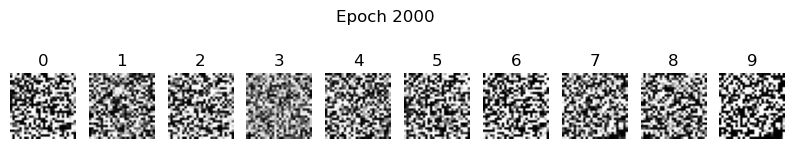

3000 [D loss: 3.5457, acc.: 32.02%] [G loss: 0.0108]


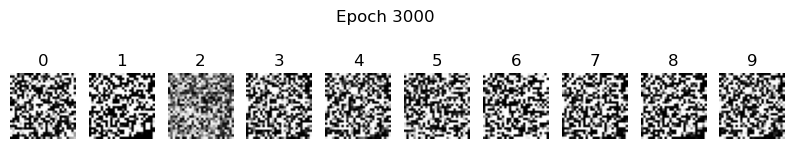

4000 [D loss: 3.7579, acc.: 32.00%] [G loss: 0.0082]


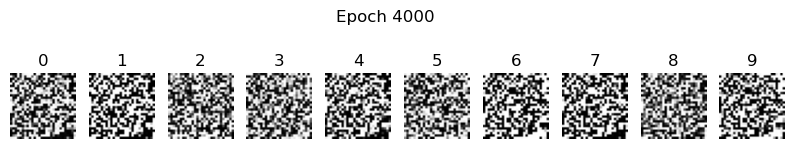

5000 [D loss: 3.9327, acc.: 31.99%] [G loss: 0.0066]


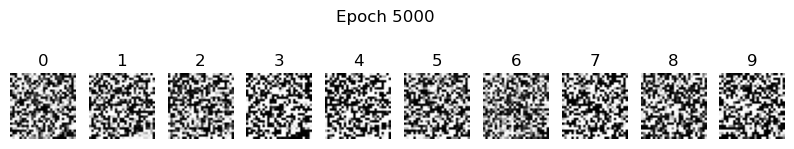

6000 [D loss: 4.0827, acc.: 32.00%] [G loss: 0.0055]


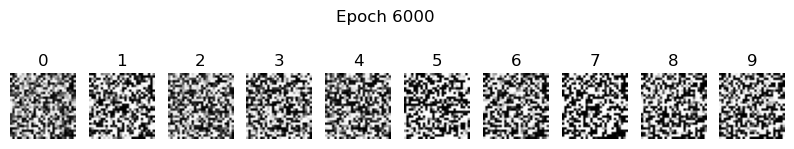

7000 [D loss: 4.2157, acc.: 32.00%] [G loss: 0.0048]


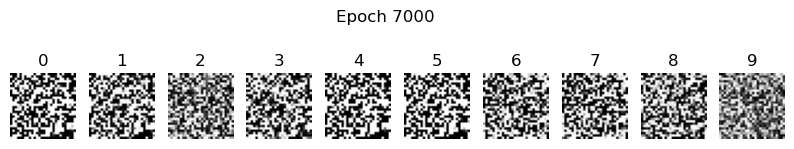

8000 [D loss: 4.3360, acc.: 32.00%] [G loss: 0.0042]


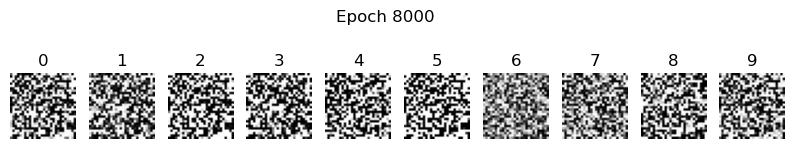

9000 [D loss: 4.4472, acc.: 32.01%] [G loss: 0.0037]


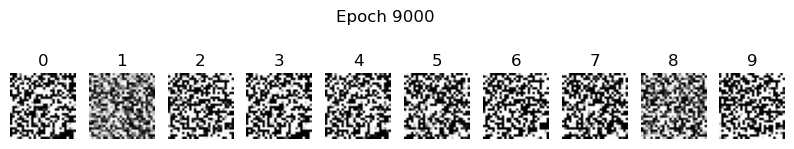

In [13]:
train_cgan(epochs=10000, batch_size=128, sample_interval=1000)